# PCA Autoencoder (Part 2)


## Synthesize dataset

In this notebook, I will just try to recreate the set of binary ellipses with only two variables (two variables) and leave out the rotation for the time being.

### Setup

In [ ]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


np.random.seed(42)
tf.random.set_seed(42)

### Phantom binary ellipses

I will use the same image dimension (64, 64) as stated in the paper. With a batch size of 500, I chose a sample size of 8000 to get 16 minibatches per epoch (it seems the total sample size was not provided in the paper, unless I missed it).

In [ ]:
def phantomEllipse(n, a, b):
    x = np.arange(n)
    R = n // 2
    y = x[:, np.newaxis]
    img = (x-R)**2/a**2 + (y-R)**2/b**2
    img[img<=1] = 1
    img[img>1] = 0
    return img

In [ ]:
n = 64
num_batch = 16
batch_size = 500
N = int(num_batch * batch_size)
random_gen = np.random.default_rng()
a = random_gen.uniform(1, n//2, N)
b = random_gen.uniform(1, n//2, N)
dataset = np.array([phantomEllipse(n, _a, _b) for _a, _b in zip(a, b)])
dataset = dataset[..., np.newaxis]  # pay attention to the shape of the dataset!

Let's look at a sample of 8 images from the dataset:

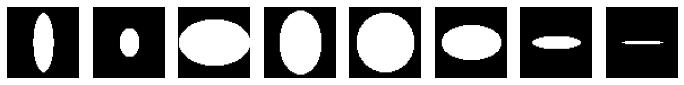

In [ ]:
frames = np.random.choice(np.arange(N), 8)
_, ax = plt.subplots(1, 8, figsize=(12, 3))
for i in range(8):
    ax[i].imshow(dataset[frames[i], ..., 0], cmap=plt.get_cmap('gray'))
    ax[i].axis("off")
plt.show()

As can be seen, the ellipses have essentially two degrees of freedom (horizontal and vertical axes). Ideally, a latent space containing two codes in the autoencoder should suffice to capture these two main features in the dataset. Let's see what a traditional CNN-autoencoder could do.

## PCA Autoencoder

I will not strictly follow model structure presented in the paper. I will adopt a more conventional "pyramid" architecture with increasing filters in the encoder hidden layers (and vice versa for the decoder). The goal here is not to optimize the autoencoder to minimize the losses. The focus is rather on the functional differences between autoencoder and PCA encoder introduced by the authors.

### Covariance loss

To implement the additional covariance loss term, a custom layer will be created for utilizing the `.add_loss()` method built into the standard `keras.layers.Layer`. 

In [ ]:
class LatentCovarianceLayer(keras.layers.Layer):
    def __init__(self, lam=0.1, **kwargs):
        super().__init__(**kwargs)
        self.lam = lam
    def call(self, inputs):
        covariance = self.lam * tf.math.reduce_mean(tf.math.reduce_prod(inputs, 1))
        self.add_loss(tf.math.abs(covariance))
        return inputs
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "lam":self.lam,}

### Standard autoencoder components

In [ ]:
def encoder_gen(inputs):
    x = keras.layers.Conv2D(4, (3, 3), padding='same')(inputs)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Conv2D(8, (3, 3), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Conv2D(16, (3, 3), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Conv2D(32, (3, 3), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Conv2D(64, (3, 3), padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization(scale=False, center=False)(x)
    x = keras.layers.Dense(1)(x)
    x = keras.layers.LeakyReLU()(x)  

    return x

def decoder_gen(inputs):
    x = keras.layers.Dense(16)(inputs)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Reshape((2, 2, 4))(x)
    x = keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2DTranspose(16, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2DTranspose(8, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2DTranspose(4, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same')(x)
    return x

### Autonencoder 1


In [ ]:
keras.backend.clear_session()

input_img = keras.layers.Input(shape=[64, 64, 1])
encoded = encoder_gen(input_img)
decoded = decoder_gen(encoded)
pca_ae = keras.models.Model(input_img, decoded)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
pca_ae.compile(optimizer=optimizer, loss='mse')

tempfn='./model_0.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=pca_ae.fit(dataset, dataset,
                   epochs=1000,
                   batch_size=500,
                   shuffle=True,
                   callbacks=cb)

Epoch 1/1000
16/16 [==============================] - 31s 54ms/step - loss: 0.1976

Epoch 00001: loss improved from inf to 0.19760, saving model to ./model_0.hdf5
Epoch 2/1000
16/16 [==============================] - 1s 53ms/step - loss: 0.1620

Epoch 00002: loss improved from 0.19760 to 0.16198, saving model to ./model_0.hdf5
Epoch 3/1000
16/16 [==============================] - 1s 54ms/step - loss: 0.1193

Epoch 00003: loss improved from 0.16198 to 0.11930, saving model to ./model_0.hdf5
Epoch 4/1000
16/16 [==============================] - 1s 53ms/step - loss: 0.0794

Epoch 00004: loss improved from 0.11930 to 0.07945, saving model to ./model_0.hdf5
Epoch 5/1000
16/16 [==============================] - 1s 54ms/step - loss: 0.0651

Epoch 00005: loss improved from 0.07945 to 0.06514, saving model to ./model_0.hdf5
Epoch 6/1000
16/16 [==============================] - 1s 52ms/step - loss: 0.0600

Epoch 00006: loss improved from 0.06514 to 0.05998, saving model to ./model_0.hdf5
Epoch 7

### Examine the results

Let's load the best model and test it on a frame first.

In [ ]:
model_0 = keras.models.load_model('model_0.hdf5')

In [ ]:
def edit_name(model, name):
  for layer in model.layers:
      layer._name = name + '_' + layer._name 
  for i in range(len(model_0.weights)):
      model_0.weights[i]._handle_name = name + '_' + model_0.weights[i].name

In [ ]:
edit_name(model_0, 'model_0')

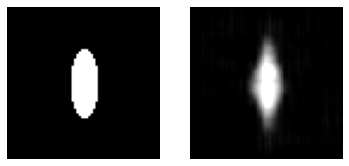

In [ ]:
img = dataset[1430, ...]
img_rec = model_0.predict(img[np.newaxis,...])
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(img_rec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[1].axis('off')
plt.show()

In [ ]:
decoder_0 = keras.models.Sequential(model_0.layers[-12:])


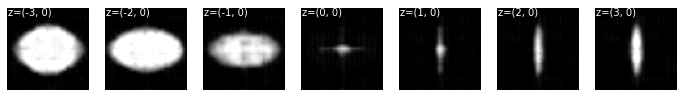

In [ ]:
vals = [-3, -2, -1, 0, 1, 2, 3]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = decoder_0.predict([vals[i]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_0_input_1 (InputLayer) [(None, 64, 64, 1)]       0         
_________________________________________________________________
model_0_conv2d (Conv2D)      (None, 64, 64, 4)         40        
_________________________________________________________________
model_0_leaky_re_lu (LeakyRe (None, 64, 64, 4)         0         
_________________________________________________________________
model_0_max_pooling2d (MaxPo (None, 32, 32, 4)         0         
_________________________________________________________________
model_0_conv2d_1 (Conv2D)    (None, 32, 32, 8)         296       
_________________________________________________________________
model_0_leaky_re_lu_1 (Leaky (None, 32, 32, 8)         0         
_________________________________________________________________
model_0_max_pooling2d_1 (Max (None, 16, 16, 8)         0     

## Autoencoder 2

In [ ]:
keras.backend.clear_session()
encoder_0 = keras.models.Model(inputs=model_0.input, outputs=model_0.get_layer('model_0_leaky_re_lu_5').output)
encoder_0.trainable = False
input_img = keras.layers.Input(shape=[64, 64, 1])
encoded_1 = encoder_gen(input_img)
encoded_0 = encoder_0(input_img)
concat = keras.layers.Concatenate()([encoded_1, encoded_0])
#activated = keras.layers.LeakyReLU()(concat)
add_loss = LatentCovarianceLayer(0.6)(concat)
decoded_1 = decoder_gen(add_loss)
pca_ae = keras.models.Model(input_img, decoded_1)

In [ ]:
pca_ae.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 4)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 4)    0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
pca_ae.compile(optimizer=optimizer, loss='mse')

tempfn='./model_1.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=pca_ae.fit(dataset, dataset,
                   epochs=1000,
                   batch_size=500,
                   shuffle=True,
                   callbacks=cb)

Epoch 1/1000
16/16 [==============================] - 3s 73ms/step - loss: 1.1478

Epoch 00001: loss improved from inf to 1.14783, saving model to ./model_1.hdf5
Epoch 2/1000
16/16 [==============================] - 1s 64ms/step - loss: 0.3879

Epoch 00002: loss improved from 1.14783 to 0.38786, saving model to ./model_1.hdf5
Epoch 3/1000
16/16 [==============================] - 1s 63ms/step - loss: 0.1822

Epoch 00003: loss improved from 0.38786 to 0.18221, saving model to ./model_1.hdf5
Epoch 4/1000
16/16 [==============================] - 1s 63ms/step - loss: 0.1264

Epoch 00004: loss improved from 0.18221 to 0.12637, saving model to ./model_1.hdf5
Epoch 5/1000
16/16 [==============================] - 1s 64ms/step - loss: 0.1027

Epoch 00005: loss improved from 0.12637 to 0.10266, saving model to ./model_1.hdf5
Epoch 6/1000
16/16 [==============================] - 1s 63ms/step - loss: 0.0898

Epoch 00006: loss improved from 0.10266 to 0.08980, saving model to ./model_1.hdf5
Epoch 7/

In [ ]:
model_1 = keras.models.load_model('model_1.hdf5', custom_objects={"LatentCovarianceLayer": LatentCovarianceLayer})

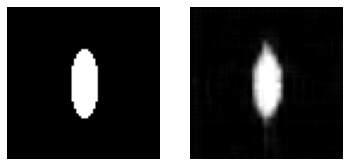

In [ ]:
img = dataset[1430, ...]
img_rec = model_1.predict(img[np.newaxis,...])
_, ax = plt.subplots(1, 2)
ax[0].imshow(img[...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[0].axis('off')
ax[1].imshow(img_rec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax[1].axis('off')
plt.show()

In [ ]:
pca_ae_decoder = keras.models.Sequential(model_1.layers[-12:])

In [ ]:
pca_ae_encoder = keras.models.Model(inputs=pca_ae.input, outputs=pca_ae.get_layer('concatenate').output)

In [ ]:
pca_ae_encoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 4)    40          input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 4)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 4)    0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [ ]:
pca_ae_encoder.predict(img[np.newaxis,...])

array([[-2.2966329e-04,  3.9284377e+00]], dtype=float32)

In [ ]:
encoder_0.predict(img[np.newaxis,...])

array([[3.9284377]], dtype=float32)

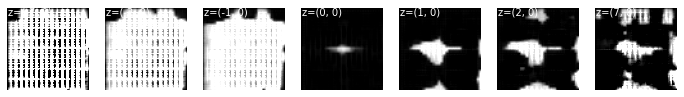

In [ ]:
vals = [-7, -2, -1, 0, 1, 2, 7]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[vals[i], 0]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()


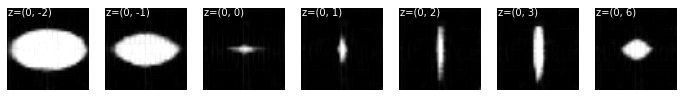

In [ ]:
vals = [-2, -1, 0, 1, 2, 3, 6]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = pca_ae_decoder.predict([[0, vals[i]]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=(0, {vals[i]})", c='w')
plt.show()

## CNN Autoencoder

For comparison, we will have a look at a conventional autoencoder without the custom layer to account for latent covariance. I will keep all the other layers the same (including the BatchNormalization to ensure similar values in the latent space).

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Conv2D(4, (3, 3), padding='same', input_shape=[64, 64, 1]),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(8, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.MaxPool2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(2),
    keras.layers.LeakyReLU(),
    #keras.layers.BatchNormalization(),
    LatentCovarianceLayer()
])

decoder = keras.models.Sequential([
    keras.layers.Dense(16, input_shape=[2]),
    keras.layers.LeakyReLU(),
    keras.layers.Reshape((2, 2, 4)),
    keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(16, (3, 3),  strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(8, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(4, (3, 3), strides=2, padding='same'),
    keras.layers.LeakyReLU(),
    keras.layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same'),
])

keras.backend.clear_session()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
pca_ae = keras.models.Sequential([encoder, decoder])
pca_ae.compile(optimizer=optimizer, loss='mse')

tempfn='./model_ae.hdf5'
model_cb=keras.callbacks.ModelCheckpoint(tempfn, monitor='loss',save_best_only=True, verbose=1)
early_cb=keras.callbacks.EarlyStopping(monitor='loss', patience=50, verbose=1)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                            patience=25,
                                                            verbose=1,
                                                            factor=0.5,
                                                            min_lr=0.00001)
cb = [model_cb, early_cb, learning_rate_reduction]

history=pca_ae.fit(dataset, dataset,
                   epochs=1000,
                   batch_size=500,
                   shuffle=True,
                   callbacks=cb)

Epoch 1/1000
16/16 [==============================] - 2s 59ms/step - loss: 0.1994

Epoch 00001: loss improved from inf to 0.19943, saving model to ./model_ae.hdf5
Epoch 2/1000
16/16 [==============================] - 1s 53ms/step - loss: 0.1751

Epoch 00002: loss improved from 0.19943 to 0.17513, saving model to ./model_ae.hdf5
Epoch 3/1000
16/16 [==============================] - 1s 53ms/step - loss: 0.1602

Epoch 00003: loss improved from 0.17513 to 0.16024, saving model to ./model_ae.hdf5
Epoch 4/1000
16/16 [==============================] - 1s 51ms/step - loss: 0.1321

Epoch 00004: loss improved from 0.16024 to 0.13208, saving model to ./model_ae.hdf5
Epoch 5/1000
16/16 [==============================] - 1s 51ms/step - loss: 0.0805

Epoch 00005: loss improved from 0.13208 to 0.08050, saving model to ./model_ae.hdf5
Epoch 6/1000
16/16 [==============================] - 1s 53ms/step - loss: 0.0617

Epoch 00006: loss improved from 0.08050 to 0.06172, saving model to ./model_ae.hdf5
Ep

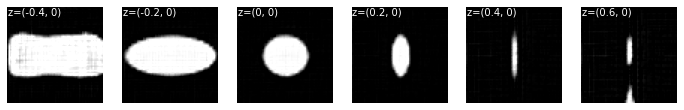

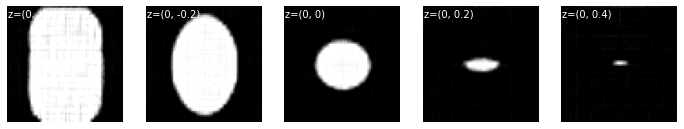

In [ ]:
ae_model = keras.models.load_model('model_ae.hdf5', custom_objects={"LatentCovarianceLayer": LatentCovarianceLayer})
ae_decoder = ae_model.layers[1]
vals = [-0.4, -0.2, 0, 0.2, 0.4, 0.6]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = ae_decoder.predict([[vals[i], 0]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=({vals[i]}, 0)", c='w')
plt.show()

vals = [-0.4, -0.2, 0, 0.2, 0.4]
_, ax = plt.subplots(1, len(vals), figsize=(12, 3))
for i in range(len(vals)):
    img_dec = ae_decoder.predict([[0, vals[i]]])
    ax[i].imshow(img_dec[0,...,0], cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    ax[i].axis("off")
    ax[i].text(0, 5, f"z=(0, {vals[i]})", c='w')
plt.show()